In [1]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import datetime
import glob
import os

# Basics of Python data handling and visualization
import numpy as np

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    FeatureType,
    LinearWorkflow,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask
)
from eolearn.features import (
    NormalizedDifferenceIndexTask,
    SimpleFilterTask
)
from eolearn.mask import AddValidDataMaskTask

## Filter Cloudy or Invalid EOPatches

In [2]:
location = 'gillam_mb_canada'
# location = 'mystery_lake_mb_canada'
# location = 'yellowknife_nt_canada'
band_names = ['B02', 'B03', 'B04', 'B08']
valid_threshold=0.9

home_dir = os.environ['HOME']
data_dir = f'{home_dir}/data/northern-cities'

### Declare predicates

In [ ]:
class MaxCCPredicate:
    """
    Predicate for filtering frames based on cloud coverage.
    """
    def __init__(self, maxcc):
        self.maxcc = maxcc

    def __call__(self, mask):
        height, width, depth = mask.shape
        cc = np.sum(mask) / (height * width)
        return cc <= self.maxcc

In [3]:
class SentinelHubValidDataPredicate:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return eopatch.mask['IS_DATA'].astype(bool) & np.logical_not(eopatch.mask['CLM'].astype(bool))

In [4]:
class ValidDataFractionPredicate:
    """
    Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

### Define tasks

In [5]:
# LOAD RAW EOPATCHES
load_raw_scenes = LoadTask(f'{data_dir}/{location}/eopatches_raw/')

# COMPUTE REFLECTANCE INDICES
add_ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDVI'),
                                         [band_names.index('B08'), band_names.index('B04')])

add_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'),
                                         [band_names.index('B03'), band_names.index('B08')])

# add_ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDBI'),
#                                          [band_names.index('B11'), band_names.index('B08')])

# COMPUTE VALID DATA MASK
add_valid_scenes_mask = AddValidDataMaskTask(SentinelHubValidDataPredicate(),
                                             'IS_VALID')

# FILTER OUT INVALID SCENES
filter_invalid_scenes = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'),
                                         ValidDataFractionPredicate(valid_threshold))

# FILTER OUT CLOUDY SCENES
# max_clouds_predicate = 
# filter_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'CLM'),
#                                         MaxCCPredicate(maxcc=0.01))

# FEATURE CONCATENATION
# concatenate_features = MergeFeatureTask({FeatureType.DATA: ['BANDS', 'NDVI', 'NDWI']},
concatenate_features = MergeFeatureTask({FeatureType.DATA: ['BANDS']},
                                        (FeatureType.DATA, 'FEATURES'))

# # LINEAR TEMPORAL INTERPOLATION
# interpolate_features = LinearInterpolationTask('FEATURES',
#                                                mask_feature=(FeatureType.MASK, 'IS_VALID'),
#                                                resample_range=('2020-01-01', '2020-12-31', 3))

# SAVE CLEAN AND INTERPOLATED EOPATCHES
save_clean_scenes = SaveTask(f'{data_dir}/{location}/eopatches_clean/',
                             overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### Define workflow

In [6]:
workflow = LinearWorkflow(
    [load_raw_scenes, "Load Raw Scenes"],
    [add_valid_scenes_mask, "Add Validation Mask"],
    [filter_invalid_scenes, "Filter Cloudy or Invalid Scenes"],
    [concatenate_features, "Concatenate Features"],
    [save_clean_scenes, "Save Clean Scenes"]
)

### Visualize workflow

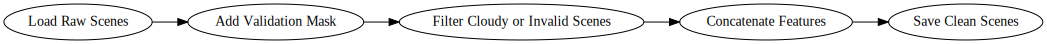

In [8]:
workflow.dependency_graph()

### Prepare execution arguments

In [9]:
num_eopatches = len(glob.glob(f'{data_dir}/{location}/eopatches_raw/eopatch-*'))

execution_args = []

for idx in range(num_eopatches):
    print(f'eopatch-{idx:04d}')
    execution_args.append({
        load_raw_scenes: {'eopatch_folder': f'eopatch-{idx:04d}'},
        save_clean_scenes: {'eopatch_folder': f'eopatch-{idx:04d}'}
    })

len(execution_args)

eopatch-0000
eopatch-0001
eopatch-0002
eopatch-0003
eopatch-0004
eopatch-0005
eopatch-0006
eopatch-0007
eopatch-0008
eopatch-0009
eopatch-0010
eopatch-0011
eopatch-0012
eopatch-0013
eopatch-0014
eopatch-0015
eopatch-0016
eopatch-0017
eopatch-0018
eopatch-0019
eopatch-0020
eopatch-0021
eopatch-0022
eopatch-0023
eopatch-0024
eopatch-0025
eopatch-0026
eopatch-0027
eopatch-0028
eopatch-0029
eopatch-0030
eopatch-0031
eopatch-0032
eopatch-0033
eopatch-0034
eopatch-0035
eopatch-0036
eopatch-0037
eopatch-0038
eopatch-0039
eopatch-0040
eopatch-0041
eopatch-0042
eopatch-0043
eopatch-0044
eopatch-0045
eopatch-0046
eopatch-0047
eopatch-0048
eopatch-0049
eopatch-0050
eopatch-0051
eopatch-0052
eopatch-0053
eopatch-0054
eopatch-0055
eopatch-0056
eopatch-0057
eopatch-0058
eopatch-0059
eopatch-0060
eopatch-0061
eopatch-0062
eopatch-0063
eopatch-0064
eopatch-0065
eopatch-0066
eopatch-0067
eopatch-0068
eopatch-0069
eopatch-0070
eopatch-0071
eopatch-0072
eopatch-0073
eopatch-0074
eopatch-0075
eopatch-0076

455

### Execute workflow

In [10]:
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=True)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

  0%|          | 0/455 [00:00<?, ?it/s]